This notebook is part of the supplementary material of the work.


**Related Reference:** "GPU-optimized Matrix Method for Phase Retrieval with the Transport of Intensity Equation" Alejandro Silva and Julia Alonso.

Last modified on 10/10/2024


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# !pip install numpy scipy matplotlib tqdm

In [3]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from tqdm import tqdm
import time
from math import comb
import cupy as cp
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import filters, measure
import os
import pandas as pd


**Propagation of the complex electric field**

In [4]:
def numerical_propagation(U0z, dz, pixelsize, lambda_, method):
    if method == 'Angular Spectrum':
        k = 2 * cp.pi / lambda_
        Nx, Ny = U0z.shape
        fx = cp.fft.fftfreq(Nx, pixelsize)
        fy = cp.fft.fftfreq(Ny, pixelsize)
        FX, FY = cp.meshgrid(fx, fy)
        H = cp.exp(1j * dz * cp.sqrt(k**2 - (2 * cp.pi * FX)**2 - (2 * cp.pi * FY)**2))
        U1z = cp.fft.ifft2(cp.fft.fft2(U0z) * H)
        I1z = cp.abs(U1z)**2
        return U1z, I1z


**FFT Solution Method**

In [5]:
def TIE_FFT_solution(dIdz, I0, Pixelsize, k, RegPara, IntThr, True_phase=None):
    t0 = time.time()
    J = -k * dIdz
    Ny, Nx = J.shape
    Fx = (cp.arange(-Nx/2, Nx/2)) / Nx / Pixelsize
    Fy = (cp.arange(-Ny/2, Ny/2)) / Ny / Pixelsize
    U, V = cp.meshgrid(Fx, Fy)
    Lambda = 2 * cp.pi / k

    fx = cp.fft.fftshift(U)
    fy = cp.fft.fftshift(V)

    Cx = 2j * cp.pi * fx
    Cy = 2j * cp.pi * fy

    FJ = cp.fft.fft2(J)
    Fpsi = FJ * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)

    Fdpsidx = Fpsi * Cx
    Fdpsidy = Fpsi * Cy
    dpsidx = cp.real(cp.fft.ifft2(Fdpsidx))
    dpsidy = cp.real(cp.fft.ifft2(Fdpsidy))

    I0[I0 < IntThr * cp.max(I0)] = IntThr * cp.max(I0)

    dPhidx = dpsidx / I0
    dPhidy = dpsidy / I0

    FdPsidx = cp.fft.fft2(dPhidx)
    FdPsidy = cp.fft.fft2(dPhidy)

    Fd2Phidx2 = FdPsidx * Cx
    Fd2Phidy2 = FdPsidy * Cy

    d2Phidx2 = cp.real(cp.fft.ifft2(Fd2Phidx2))
    d2Phidy2 = cp.real(cp.fft.ifft2(Fd2Phidy2))
    d2Phi = d2Phidx2 + d2Phidy2

    Fd2Phi = cp.fft.fft2(d2Phi)
    Fphi = Fd2Phi * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)
    Phi = cp.real(cp.fft.ifft2(Fphi))

    t1 = time.time()
    Time = t1 - t0

    RMSE = None
    if True_phase is not None:
        err = Phi - True_phase
        err = err - cp.nanmean(err)
        RMSE = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))

    return Phi, RMSE, Time

**iterDCT Solution Method**

In [19]:

def EvenFlip(A):
    temp = cp.concatenate((A, cp.fliplr(A)), axis=1)
    AA = cp.concatenate((temp, cp.flipud(temp)), axis=0)
    return AA

def TIE_DCT_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, RegPara, Method):
    dIdz_double = EvenFlip(dIdz_curr)
    Phi_curr_double = EvenFlip(Phi_curr)
    I0_double = EvenFlip(I0)
    Lambda = 2 * cp.pi / k

    J = -k * dIdz_double
    Ny, Nx = J.shape
    Fx = (cp.arange(-Nx/2, Nx/2)) / Nx / Pixelsize
    Fy = (cp.arange(-Ny/2, Ny/2)) / Ny / Pixelsize
    U, V = cp.meshgrid(Fx, Fy)

    fx = cp.fft.fftshift(U)
    fy = cp.fft.fftshift(V)

    Cx = 2j * cp.pi * fx
    Cy = 2j * cp.pi * fy

    FJ = cp.fft.fft2(J)
    Fpsi = FJ * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)

    Fdpsidx = Fpsi * Cx
    Fdpsidy = Fpsi * Cy
    dpsidx = cp.real(cp.fft.ifft2(Fdpsidx))
    dpsidy = cp.real(cp.fft.ifft2(Fdpsidy))

    I0_double[I0_double < 0.01 * cp.max(I0_double)] = cp.mean(I0_double)

    dPhidx = dpsidx / I0_double
    dPhidy = dpsidy / I0_double

    FdPsidx = cp.fft.fft2(dPhidx)
    FdPsidy = cp.fft.fft2(dPhidy)

    Fd2Phidx2 = FdPsidx * Cx
    Fd2Phidy2 = FdPsidy * Cy

    d2Phidx2 = cp.real(cp.fft.ifft2(Fd2Phidx2))
    d2Phidy2 = cp.real(cp.fft.ifft2(Fd2Phidy2))
    d2Phi = d2Phidx2 + d2Phidy2

    Fd2Phi = cp.fft.fft2(d2Phi)
    Fphi = Fd2Phi * (Cx**2 + Cy**2) / (RegPara / Pixelsize**4 + (Cx**2 + Cy**2)**2)
    Phi_double = cp.real(cp.fft.ifft2(Fphi))

    Phi = Phi_double[:Ny//2, :Nx//2]

    if Method == 'TIE':
        Fdphidx = Fphi * Cx
        Fdphidy = Fphi * Cy
        dphidx = cp.real(cp.fft.ifft2(Fdphidx))
        dphidy = cp.real(cp.fft.ifft2(Fdphidy))
        dPsidx = I0_double * dphidx
        dPsidy = I0_double * dphidy
        FdPsidx = cp.fft.fft2(dPsidx)
        FdPsidy = cp.fft.fft2(dPsidy)
        Fd2Psidx2 = FdPsidx * Cx
        Fd2Psidy2 = FdPsidy * Cy
        d2Psidx2 = cp.real(cp.fft.ifft2(Fd2Psidx2))
        d2Psidy2 = cp.real(cp.fft.ifft2(Fd2Psidy2))
        laplacePsi = d2Psidx2 + d2Psidy2
        dIdz_est = laplacePsi / -k
        dIdz_est = Phi_double[:Ny//2, :Nx//2]

    elif Method == 'Angular Spectrum':
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0_double) * cp.exp(1j * (Phi_double + Phi_curr_double))))
        Exp_term = cp.sqrt(1 - (Lambda * U)**2 - (Lambda * V)**2)
        H = cp.exp(1j * k * dz * Exp_term)
        H[(1 - (Lambda * U)**2 - (Lambda * V)**2) < 0] = 0
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0_double) / dz
        dIdz_est = dIdz_est[:Ny//2, :Nx//2]

    elif Method == 'Fresnel':
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0_double) * cp.exp(1j * (Phi_double + Phi_curr_double))))
        H = cp.exp(1j * k * dz * (1 - ((Lambda * U)**2 + (Lambda * V)**2) / 2))
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0_double) / dz
        dIdz_est = dIdz_est[:Ny//2, :Nx//2]

    else:
        raise ValueError("Method must be 'TIE', 'Angular Spectrum', or 'Fresnel'")

    return Phi, dIdz_est

def Iter_DCT_solution(dIdz, dz, I0, Pixelsize, k, r, Iter, JudgeFlag, Method= "Angular Spectrum", True_phase=None):
    if Method not in ['TIE', 'Angular Spectrum', 'Fresnel']:
        raise ValueError("Method must be 'TIE', 'Angular Spectrum', or 'Fresnel'")

    RMSE = []
    Time = []

    dIdz_curr = dIdz
    Phi_curr = cp.zeros_like(dIdz)

    if True_phase is not None:
        err = Phi_curr - True_phase
        err = err - cp.mean(err[~cp.isnan(err)])
        RMSE_Temp = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))
        RMSE.append(RMSE_Temp)

    for n in range(Iter):
        t0 = time.time()
        Phi_est, dIdz_est = TIE_DCT_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method)
        t1 = time.time()
        t2 = t1 - t0

        dIdz_temp = dIdz_curr
        if Method == 'TIE':
            dIdz_curr -= dIdz_est
        else:
            dIdz_curr = dIdz - dIdz_est

        Phi_curr += Phi_est

        if True_phase is not None:
            err = Phi_curr - True_phase
            err = err - cp.mean(err[~cp.isnan(err)])
            RMSE_Temp = cp.sqrt(cp.nansum(err**2) / (err.size - cp.isnan(err).sum()))
            RMSE.append(RMSE_Temp)
            Time.append(t2)

        if JudgeFlag:
            if cp.max(dIdz_curr) < cp.max(dIdz) * 1e-3 or cp.max(dIdz_curr) > 1.05 * cp.max(dIdz_temp):
                print(f'Iter-DCT-TIE iteration time: {n + 1}')
                break
        if n == Iter - 1:
            print(f'Iter-DCT-TIE iteration time: {Iter}')

    return Phi_curr, RMSE, Time

**Universal Solution Method (US-TIE)**

In [7]:
def TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method):
    J = -k * dIdz_curr
    Ny, Nx = J.shape
    Lambda = 2 * cp.pi / k
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Nx, Pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Ny, Pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)

    # Calculate phi assuming uniform intensity.
    FJ = cp.fft.fft2(J / cp.max(I0))
    Fphi = FJ * (Cx * Cx + Cy * Cy) / (r / Pixelsize ** 4 + (Cx * Cx + Cy * Cy) ** 2)
    Phi = cp.real(cp.fft.ifft2(Fphi))

    if Method == 'TIE':
        # Calculate the estimate of dIdz using TIE
        Fdphidx = Fphi * Cx
        Fdphidy = Fphi * Cy
        dphidx = cp.real(cp.fft.ifft2(Fdphidx))
        dphidy = cp.real(cp.fft.ifft2(Fdphidy))
        dPsidx = I0 * dphidx
        dPsidy = I0 * dphidy
        FdPsidx = cp.fft.fft2(dPsidx)
        FdPsidy = cp.fft.fft2(dPsidy)
        Fd2Psidx2 = FdPsidx * Cx
        Fd2Psidy2 = FdPsidy * Cy
        d2Psidx2 = cp.real(cp.fft.ifft2(Fd2Psidx2))
        d2Psidy2 = cp.real(cp.fft.ifft2(Fd2Psidy2))
        laplacePsi = d2Psidx2 + d2Psidy2
        # Estimate dIdz
        dIdz_est = laplacePsi / (-k)

    elif Method == 'Angular Spectrum':
        # Calculate the estimate of dIdz using Angular Spectrum
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        Exp_term = cp.sqrt(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2)
        H = cp.exp(1j * k * dz * Exp_term)
        H[(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2) < 0] = 0  # neglect evanescent wave
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    elif Method == 'Fresnel':
        # Calculate the estimate of dIdz using Fresnel method
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        H = cp.exp(1j * k * dz * (1 - ((Lambda * U) ** 2 + (Lambda * V) ** 2) / 2))
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    else:
        raise ValueError("Type of transfer function must be 'Angular Spectrum' or 'Fresnel'")

    return Phi, dIdz_est



def Universal_Solution(dIdz, dz, I0, Pixelsize, k, r, Iter, JudgeFlag, Method='TIE', True_phase=None):
    if Method not in ['TIE', 'Angular Spectrum', 'Fresnel']:
        raise ValueError("Currently 'Method' only allows 'TIE', 'Angular Spectrum' or 'Fresnel'.")

    RMSE = []
    Time = []

    dIdz_curr = cp.array(dIdz)
    dIdz_temp = cp.array(dIdz)

    Phi_curr = cp.zeros_like(dIdz_curr)

    if True_phase is not None:
        err = Phi_curr - cp.array(True_phase)
        err = err - cp.mean(err[~cp.isnan(err)])
        valid_elements = ~cp.isnan(err)
        RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
        RMSE.append(RMSE_Temp)

    for n in tqdm(range(1, Iter + 1)):
        # Estimate Phase with TIE_MAX_solver
        t0 = time.time()
        Phi_est, dIdz_est = TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method)
        t1 = time.time()
        t2 = t1 - t0
        dIdz_temp = dIdz_curr

        # Calculate dIdz Error
        if Method == 'TIE':
            dIdz_curr = dIdz_curr - dIdz_est
        elif Method in ['Fresnel', 'Angular Spectrum']:
            dIdz_curr = cp.array(dIdz) - dIdz_est

        # Current Phase Estimate
        Phi_curr = Phi_curr + Phi_est

        # Calculate RMSE
        if True_phase is not None:
            err = Phi_curr - cp.array(True_phase)
            err = err - cp.mean(err[~cp.isnan(err)])
            valid_elements = ~cp.isnan(err)
            RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
            RMSE.append(RMSE_Temp)
            Time.append(t2)

        # Check Convergence
        if JudgeFlag:
            if (cp.max(dIdz_curr) < cp.max(cp.array(dIdz)) * 1e-3 or cp.max(dIdz_curr) > 1.05 * cp.max(dIdz_temp)):
                print(f'US-TIE iteration time: {n}')
                break
        if n == Iter:
            print(f'US-TIE iteration time: {Iter}')

    Phi = Phi_curr.get()
    return Phi, RMSE, Time



**Matrix Solution Method (MS-TIE)**

In [20]:
def conv2(A, B):
    """
    A es la fft
    """
    return cp.fft.fft2(A * cp.fft.ifft2(B, axes=(0, 1)), axes=(0, 1))

def Phase_Retrieve(I0, pixelsize, dIdz, Iter, r,k, Method='TIE'):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    if Method == "TIE":
      Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      Filter_tie[:,:,0] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,1] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,2] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)

      I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      I[:,:,0] = I0
      I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
      I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

      M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      M[:,:,0] = (Cx * Cx + Cy * Cy)
      M[:,:,1] = Cx
      M[:,:,2] = Cy

      FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
      FJ = Filter_tie * FJ * (-k)

      Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
      M_ones = cp.ones((3, 3), dtype = cp.complex64)
      t1 = time.time()
      for n in tqdm(range(Iter)):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

      Fphi_curr += FJ
      time_exe = time.time() - t1
      return cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))), time_exe



MAIN:

In [9]:
# PARAMETERS
ITER = 100
dz = 1e-6
pixelsize = 2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01


In [10]:
CASE = 1

In [11]:
# CASE 1
if CASE == 1:
  file_path_io = './Data/sim1/SCILab_Blur.tif'
  file_path_phase = './Data/sim1/TIE_Multiple_Blur2.tif'
  Io =cv2.imread(file_path_io, cv2.IMREAD_GRAYSCALE).astype(np.float64)/255
  Phase = cv2.imread(file_path_phase, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255
  Nx,Ny = Io.shape
##########################################################################################################################################################
# CASE 2
if CASE == 2:
  sigma = 3e-4
  file_path = './Data/sim2/DeltaPhi_test.mat'
  Phase = sio.loadmat(file_path)['Delta_Phi']
  Nx,Ny = Phase.shape
  x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)
  Io = cp.exp((-x**2 - y**2) / (2 * sigma**2))

##########################################################################################################################################################


I0 = cp.asarray(Io)
Phi = cp.asarray(Phase)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)




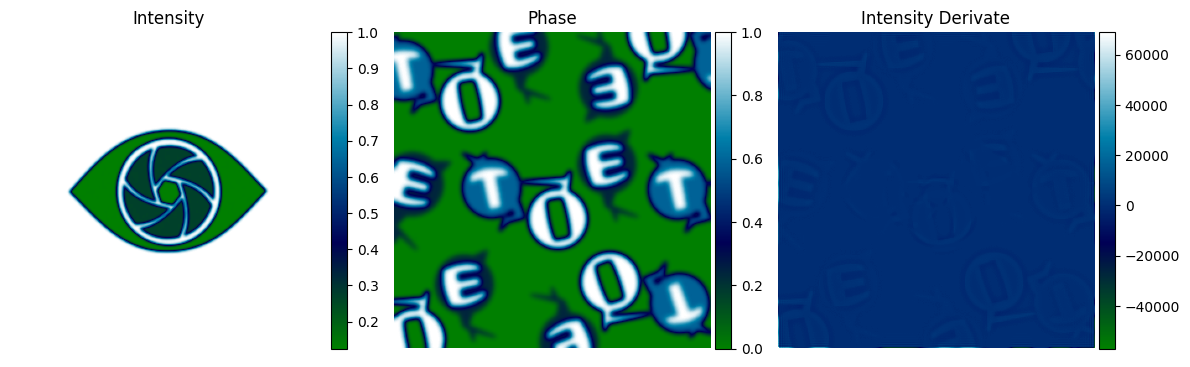

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()

**FFT Solution**

Execution time: 
 0.008259773254394531 s
RMSE:  0.08649315664042492
Phase map


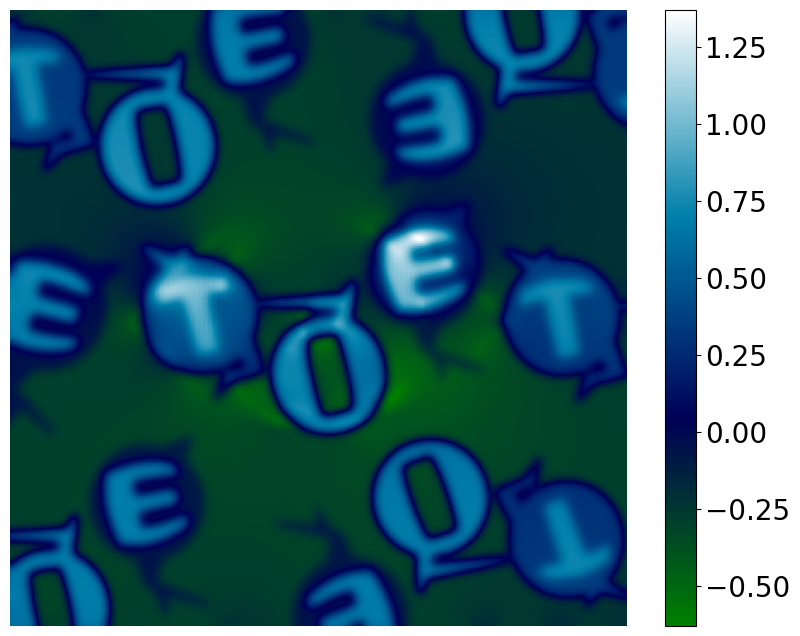


Error map


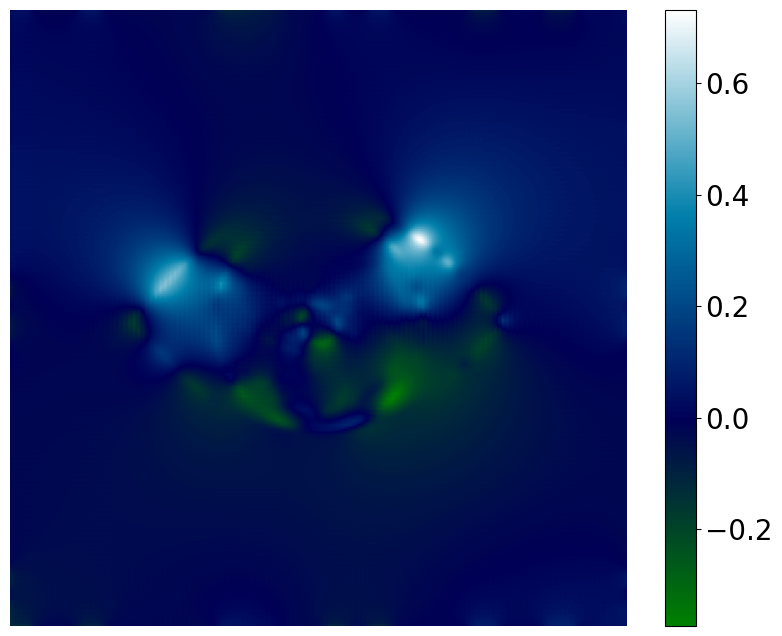

In [16]:

start_time = time.time()
Phi_rec_fft, RMSE_fft, Time_fft = TIE_FFT_solution(dIdz.copy(), I0.copy(), pixelsize, k, r, IntThr)
end_time = time.time()
execution_time_fft = end_time - start_time
print(f"Execution time: \n {execution_time_fft} s")

True_phase_fft = cp.asarray(Phi)
err_fft = cp.asarray(Phi_rec_fft) - True_phase_fft
err_fft = err_fft - cp.nanmean(err_fft)
valid_elements_fft = ~cp.isnan(err_fft)
RMSE_fft = cp.sqrt(cp.sum(err_fft[valid_elements_fft]**2) / cp.sum(valid_elements_fft))

print('RMSE: ', RMSE_fft.get())  # Convert to numpy array


print("Phase map")
plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_fft.get(), cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

print()

print("Error map")
plt.figure(figsize=(10, 8))
plt.imshow(err_fft.get(), cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

**iterDCT Solution**

Iter-DCT-TIE iteration time: 3
Execution time: 
 5.503164768218994 s
RMSE:  42.786106257631246
Phase map


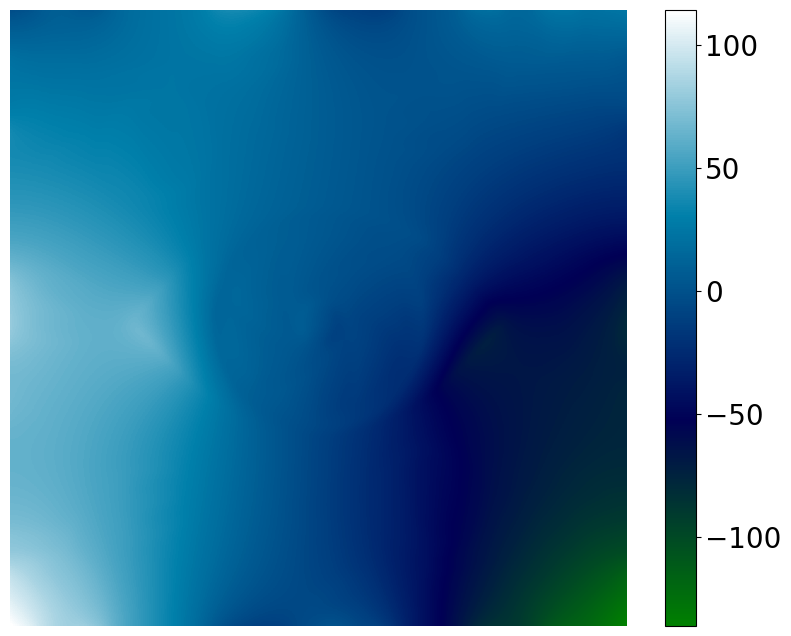


Error map


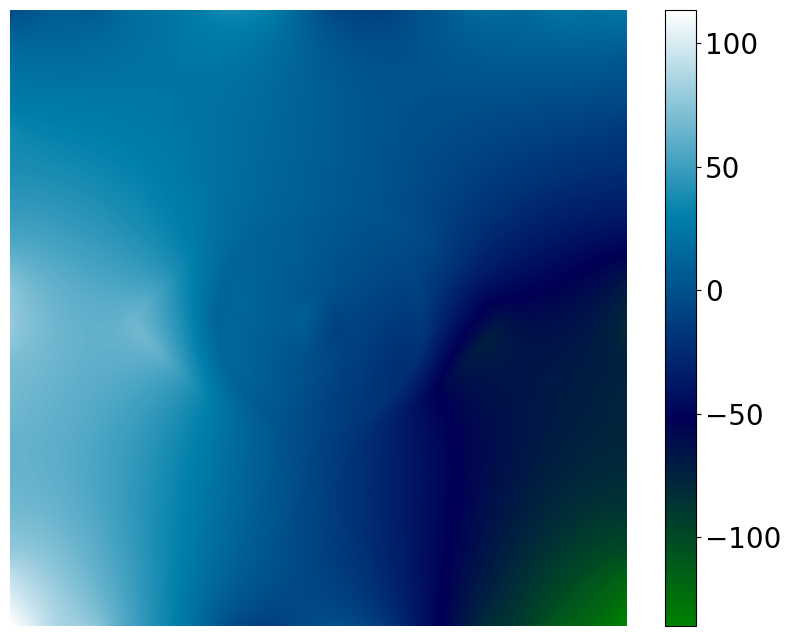

In [18]:


start_time = time.time()
Phi_rec_iterdct, RMSE_iterdct, Time_iterdct = Iter_DCT_solution(dIdz.copy(), dz, I0.copy(), pixelsize, k, r, ITER, 1)

end_time = time.time()
execution_time_iterdct = end_time - start_time
print(f"Execution time: \n {execution_time_iterdct} s")

True_phase_iterdct = cp.asarray(Phi)
err_iterdct = cp.asarray(Phi_rec_iterdct) - True_phase_iterdct
err_iterdct = err_iterdct - cp.nanmean(err_iterdct)
valid_elements_iterdct = ~cp.isnan(err_iterdct)
RMSE_iterdct = cp.sqrt(cp.sum(err_iterdct[valid_elements_iterdct]**2) / cp.sum(valid_elements_iterdct))

print('RMSE: ', RMSE_iterdct)

print("Phase map")
plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_iterdct.get(), cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show()

print()
print("Error map")
plt.figure(figsize=(10, 8))
plt.imshow(err_iterdct.get(), cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()


US - TIE


100%|██████████| 100/100 [00:00<00:00, 245.95it/s]


US-TIE iteration time: 100
Tiempo de ejecución: 
 0.4221649169921875 segundos
RMSE:  0.12330518235469826


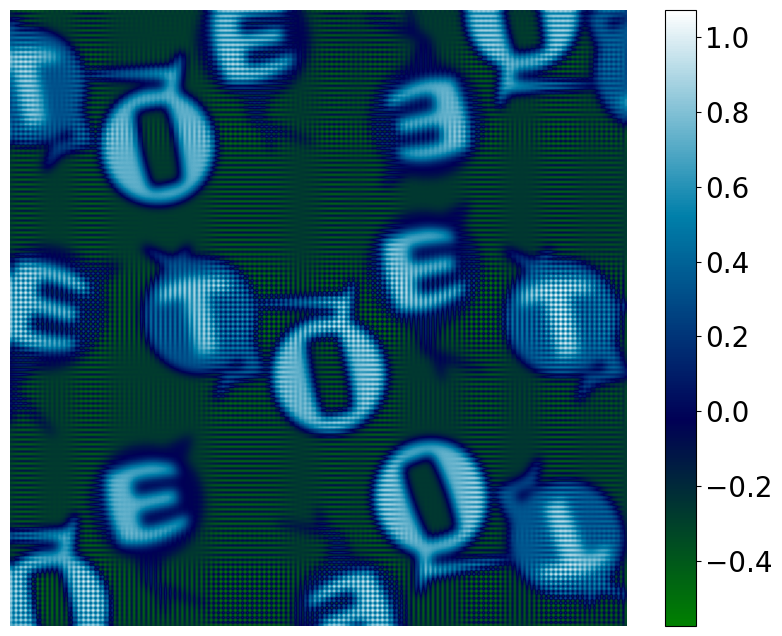

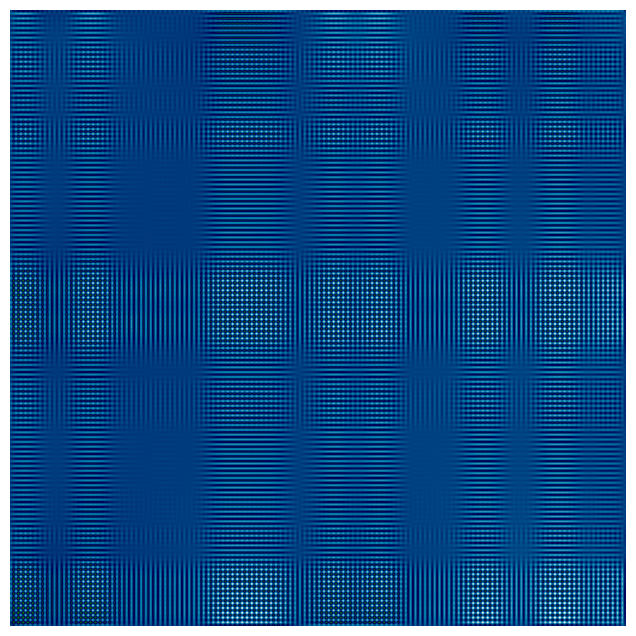

In [34]:
start_time = time.time()
Phi_rec_us_tie, RMSE_us_tie, Time_us_tie = Universal_Solution(dIdz.copy(), dz, I0.copy(), pixelsize, k, r, ITER, 0,Method='TIE')
end_time = time.time()
execution_time_us_tie = end_time - start_time
print(f"Tiempo de ejecución: \n {execution_time_us_tie} segundos")

True_phase_us = cp.asarray(Phi)
err_us_tie = cp.asarray(Phi_rec_us_tie) - True_phase_us
err_us_tie = err_us_tie - cp.nanmean(err_us_tie)
valid_elements_us = ~cp.isnan(err_us_tie)
RMSE_us_tie = cp.sqrt(cp.sum(err_us_tie[valid_elements_us]**2) / cp.sum(valid_elements_us))

print('RMSE: ', RMSE_us_tie.get())


plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_us_tie, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

print()

plt.figure(figsize=(10, 8))
if CASE == 1:
  min_val = -0.3
  max_val = 0.3
  plt.imshow(err_us_tie.get(), cmap='ocean', vmin=min_val, vmax=max_val)
if CASE == 2:
  min_val = -0.04
  max_val = 0.04
  plt.imshow(err_us_tie.get(), cmap='ocean', vmin=min_val, vmax=max_val)
else:
  plt.imshow(err_us_tie.get(), cmap='ocean')
plt.axis('off')
plt.show()



METHOD OUR - TIE

100%|██████████| 100/100 [00:00<00:00, 1694.25it/s]


Tiempo de ejecución: 
 0.06415319442749023 segundos
RMSE:  0.013990930271448402


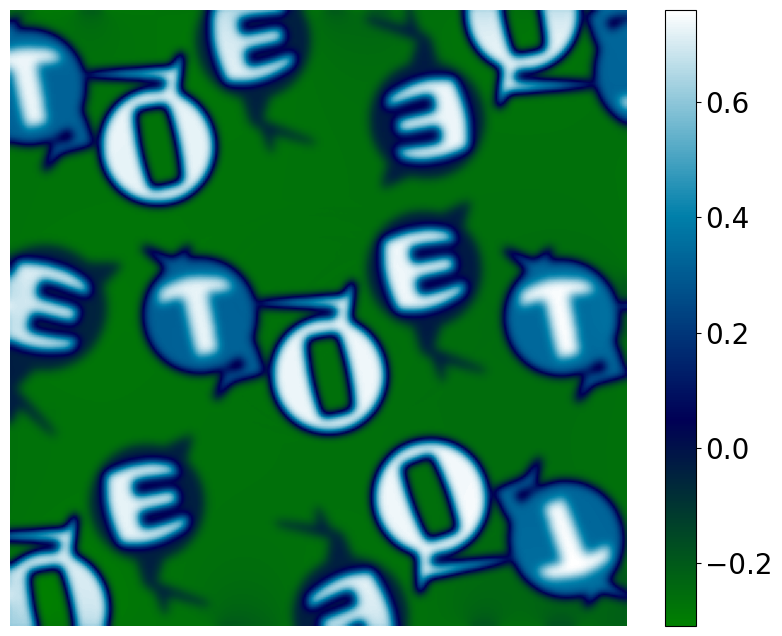

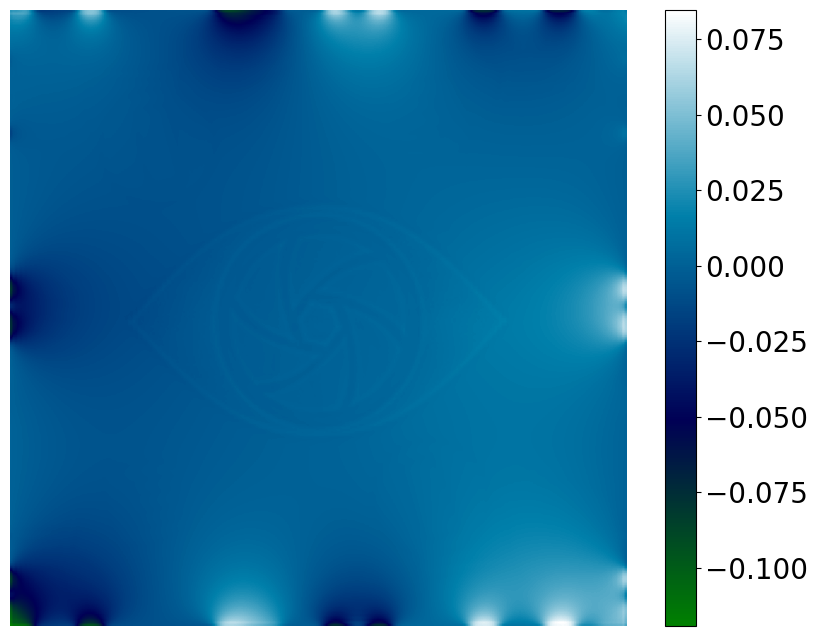

In [33]:
Method_estimate = 'TIE'

Phi_rec_mas_tie, execution_time_mas_tie = Phase_Retrieve(I0.copy(), pixelsize, dIdz.copy(), ITER, r,k)

print(f"Tiempo de ejecución: \n {execution_time_mas_tie} segundos")

True_phase_mas = Phi
err_mas_tie = Phi_rec_mas_tie - True_phase_mas
err_mas_tie = err_mas_tie - cp.nanmean(err_mas_tie)
valid_elements_mas = ~cp.isnan(err_mas_tie)
RMSE_mas_tie = cp.sqrt(cp.sum(err_mas_tie[valid_elements_mas]**2) / cp.sum(valid_elements_mas))

print('RMSE: ', RMSE_mas_tie.get())


plt.figure(figsize=(10, 8))
plt.imshow(Phi_rec_mas_tie.get(), cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

print()

plt.figure(figsize=(10, 8))
if CASE == 1:
  min_val = -0.3
  max_val = 0.3
  plt.imshow(err_mas_tie.get(), cmap='ocean', vmin=min_val, vmax=max_val)
if CASE == 2:
  min_val = -0.04
  max_val = 0.04
  plt.imshow(err_mas_tie.get(), cmap='ocean', vmin=min_val, vmax=max_val)

else:
  plt.imshow(err_mas_tie.get(), cmap='ocean')

plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()



RESULTADOS GENERALES

In [31]:

dict_rmse = {'FFT: ':RMSE_fft.get(),
'iterDCT: ': RMSE_iterdct.get(),
'US-TIE: ':RMSE_us_tie.get(),
'mAS-TIE: ': RMSE_mas_tie.get()}

df_rmse = pd.DataFrame.from_dict(dict_rmse, orient='index', columns=['RMSE'])

print(df_rmse)


                RMSE
FFT:        0.086493
iterDCT:   42.786106
US-TIE:     0.123305
mAS-TIE:    0.013991


In [35]:
dict_time = {'FFT: ':execution_time_fft,
'iterDCT: ': execution_time_iterdct,
'US-TIE: ':execution_time_us_tie,
'mAS-TIE: ': execution_time_mas_tie}

df_time = pd.DataFrame.from_dict(dict_time, orient='index', columns=['Time (s)'])

print(df_time)

           Time (s)
FFT:       0.008260
iterDCT:   5.503165
US-TIE:    0.422165
mAS-TIE:   0.064153
